# RESOLUTION OF PDB FILES 
## Analysis of resolution in MAHOMES II database

### Libraries

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import sys
from scipy import stats
import itertools
from itertools import combinations
from biopandas.pdb import PandasPdb

### Reading files

In [9]:
sites1 = pd.read_csv('../results/sites.csv')
print(sites1.columns)
sites1.head(1)

Index(['Unnamed: 0', 'SITE_ID', 'PDB ID', 'Chain ID', 'resName1', 'resName2',
       'resName3', 'resName4', 'seqNum1', 'seqNum2', 'seqNum3', 'seqNum4',
       'Enzyme', 'Set', 'Exp. Method', 'Resolution (Å)', 'PDB Dep. Date',
       'PDB Classification', 'PDB Macromolecular Name', 'EC No', 'Uniprot Acc',
       'Uniprot Recommended Name', 'Distance  Site moved during relax (Å)',
       'Homolog M-CSA ID', 'Homolog M-CSA aligned TM_len',
       'Homolog M-CSA aligned TM_rmsd', 'Homolog M-CSA aligned TMscore',
       'M-CSA TM_seqID', 'M-CSA e_val',
       'Homolog M-CSA aligned catalytic residue distance from site'],
      dtype='object')


,Unnamed: 0,SITE_ID,PDB ID,Chain ID,resName1,resName2,resName3,resName4,seqNum1,seqNum2,...,Uniprot Acc,Uniprot Recommended Name,Distance Site moved during relax (Å),Homolog M-CSA ID,Homolog M-CSA aligned TM_len,Homolog M-CSA aligned TM_rmsd,Homolog M-CSA aligned TMscore,M-CSA TM_seqID,M-CSA e_val,Homolog M-CSA aligned catalytic residue distance from site
0,0,6s9z_0,6S9Z,A,ZN,NaN,NaN,NaN,302,NaN,...,P00918,Carbonic anhydrase 2,0.22998,M0216,256.0,0.33,0.9631,1.0,8.500000e-182,1.94291


In [10]:
# Select data to resolution by enzyme type
sites1_res = sites1[['Resolution (Å)', 'Enzyme', "Set", 'Exp. Method']]
sites1_res.shape

(3985, 4)

Text(0, 0.5, 'KDE of number PDB structures')

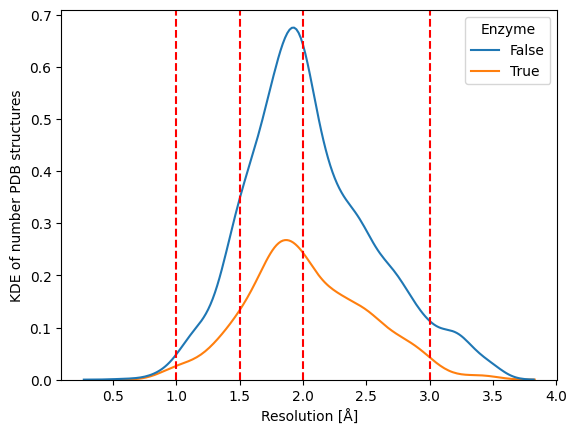

In [11]:
# Plotting the KDE Plot
sns.kdeplot(data=sites1_res, x='Resolution (Å)', hue = 'Enzyme')#, palette={False: 'black', True: 'blue'})
plt.axvline(x=1.0, color='red', linestyle='--', lw=1.5)
plt.axvline(x=1.5, color='red', linestyle='--', lw=1.5)
plt.axvline(x=2.0, color='red', linestyle='--', lw=1.5)
plt.axvline(x=3.0, color='red', linestyle='--', lw=1.5)
plt.xlabel('Resolution [Å]')
plt.ylabel('KDE of number PDB structures')

In [12]:
# Read the PDB file using BioPandas
pdb1 = PandasPdb().read_pdb('../data/7/a/7adh_A/7adh_A_Rlx.pdb')
pdb2 = PandasPdb().read_pdb('../data/7/a/7adh_A/7adh_A_Rlx.pdb')
atom_df = pdb2.df['ATOM']
atom_df.head(2)

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,SER,,A,1,,...,-0.659,21.640,-7.277,NaN,NaN,,,N,NaN,17
1,ATOM,2,,CA,,SER,,A,1,,...,-1.892,21.613,-6.517,NaN,NaN,,,C,NaN,18


In [13]:
#pdb2table is a local copy of code to convert a PDB file into a table
import pdb2table as pdbdf
pdbtable = pdbdf.get_struc_atom_coords('../data/7/a/7adh_A/7adh_A_Rlx.pdb')
pdbtable.head(1)

,serial,atom_name,altLoc,resName,chainID,resNum,iCode,x,y,z,occupancy,tempFactor,segID,element,charge
0,1,N,,SER,A,1,,-0.65,21.64,-7.27,1.0,0.0,,N,


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_44865/2454853987.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(pqrfilepath, sep='\s+', header=None)


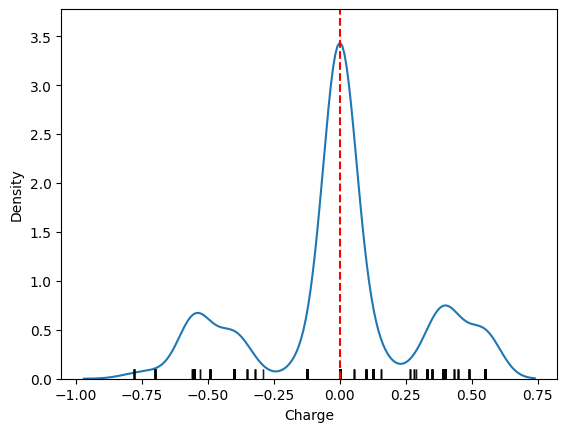

In [15]:
#PQR file is a table, it can be read using pandas.read_csv 
pqrfilepath = "../data/1/2/121p_A/121p_A.pqr"
df = pd.read_csv(pqrfilepath, sep='\s+', header=None)
df.columns = ['Type', 'Order', 'Atom', 'Res', 'ResN', 'x', 'y', 'z', 'charge', 'colx']
df = df[df['Type'] == 'ATOM']
df = df.drop(columns=['Type','Order', 'colx'])
# Plotting the KDE Plot
sns.kdeplot(data=df, x='charge')#, hue = "Res", lw=0.5)
sns.rugplot(df, x='charge', color="black", alpha=0.5).set(xlabel = "Charge", ylabel = "Density")
plt.axvline(x=0, color='red', linestyle='--', lw=1.5)

# Read PDB and PQR files

PDB: to extract HETATM values used to calculate the distance to the metal site and for electric field due to individual charges. 

PQR: to extract x, y, z, charge for residues and their atoms. 

In [16]:
#PDB file to table

def pdb2table(file_path):
    col_names_pdb = ['type','n', 'atom', 'resName', 'chain', 'resN', 'x', 'y', 'z', 
                 'occup', 'tempfctr', 'element', 'empty']
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                row_i = line.split()
                data.append(row_i)
    df = pd.DataFrame(data)
    if df.shape[1] == 12: 
        df.columns = col_names_pdb[:12]
        df = df.drop(columns = ['occup', 'tempfctr'])
    else:
        df.columns = col_names_pdb
        df = df.drop(columns = ['occup', 'tempfctr', 'empty'])
    return df
#example
pdbx = pdb2table('../data/1/s/1sum_B/1sum_B_Rlx.pdb'); pdbx[pdbx['type']== "HETATM"].head(2)

,type,n,atom,resName,chain,resN,x,y,z,element
3653,HETATM,3655,FE,FE,B,236,24.797,62.155,15.939,FE
3654,HETATM,3656,FE,FE,B,237,13.378,42.006,3.113,FE


In [17]:
#PQR file to table
def pqr2table(file_path):
    dfpqr = pd.read_csv(file_path, sep='\s+', header=None)
    dfpqr.columns = ['type', 'n', 'atom', 'resName', 'resN', 'x', 'y', 'z', 'charge', 'colx']
    dfpqr['n'] = pd.to_numeric(dfpqr['n'], errors='coerce')
    dfpqr['resN'] = pd.to_numeric(dfpqr['resN'], errors='coerce')
    dfpqr = dfpqr[dfpqr['type'] == 'ATOM']
    dfpqr = dfpqr.drop(columns=['colx'])
    return dfpqr
#example
pqrx = pqr2table('../data/1/s/1sum_B/1sum_B.pqr'); pqrx.head(2)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_44865/986197301.py:3: SyntaxWarning: invalid escape sequence '\s'
  dfpqr = pd.read_csv(file_path, sep='\s+', header=None)


,type,n,atom,resName,resN,x,y,z,charge
0,ATOM,1.0,N,ASN,2.0,34.989,69.585,13.281,-0.32
1,ATOM,2.0,CA,ASN,2.0,36.318,69.117,12.801,0.33


In [18]:
# HEATM from PDB, analyzed as single or cluster of metals 
def metal_dist(df, dist_max=5):
    df['x'] = pd.to_numeric(df['x'], errors='coerce')
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df['z'] = pd.to_numeric(df['z'], errors='coerce')
    metpairs = pd.DataFrame(columns=['atoms', 'resName', 'resN', 'x', 'y', 'z'])
    clustered_metals = set()

    for i, j in combinations(range(len(df)), 2):
        metal1 = df.iloc[i]; metal2 = df.iloc[j]
        twometals = f"{metal1['atom']}{metal1['resN']}-{metal2['atom']}{metal2['resN']}"
        distance = np.linalg.norm(metal1[['x', 'y', 'z']] - metal2[['x', 'y', 'z']])

        if distance <= dist_max:
            if metal1['atom'] + str(metal1['resN']) not in clustered_metals and metal2['atom'] + str(metal2['resN']) not in clustered_metals:
                # Create a new cluster
                clustered_metals.add(metal1['atom'] + str(metal1['resN']))
                clustered_metals.add(metal2['atom'] + str(metal2['resN']))
                avg_coords = (metal1[['x', 'y', 'z']] + metal2[['x', 'y', 'z']]) / 2
                new_row = {'atoms': twometals, 'resName': metal1['resName'], 'resN': metal1['resN'],
                           'x': avg_coords['x'], 'y': avg_coords['y'], 'z': avg_coords['z']}
                metpairs = pd.concat([metpairs, pd.DataFrame([new_row])], ignore_index=True)
            else:
                # Add metals to existing cluster
                cluster_index = metpairs[(metpairs['atoms'].str.contains(metal1['atom'] + str(metal1['resN']))) | 
                                          (metpairs['atoms'].str.contains(metal2['atom'] + str(metal2['resN'])))]
                if cluster_index.shape[0] > 0:
                    cluster_index = cluster_index.index[0]
                    cluster_row = metpairs.loc[cluster_index]
                    new_coords = (cluster_row[['x', 'y', 'z']] + metal1[['x', 'y', 'z']] + metal2[['x', 'y', 'z']]) / 3
                    metpairs.loc[cluster_index, ['x', 'y', 'z']] = new_coords
                    metpairs.loc[cluster_index, 'atoms'] += f"-{metal2['atom']}{metal2['resN']}"
                    clustered_metals.add(metal2['atom'] + str(metal2['resN']))

    # Add single atoms that aren't in any cluster
    for index, row in df.iterrows():
        if row['atom'] + str(row['resN']) not in clustered_metals:
            row['atoms'] = row['atom']
            row = row[['atoms', 'resName', 'resN', 'x', 'y', 'z']]
            metpairs = pd.concat([metpairs, row.to_frame().T], ignore_index=True)

    return metpairs
#example
pdb_dfx = pdb2table('../data/1/s/1sum_B/1sum_B_Rlx.pdb')[pdb2table('../data/1/s/1sum_B/1sum_B_Rlx.pdb')['type']=='HETATM']
metalx = metal_dist(pdb_dfx, 5); metalx.head(2)

/tmp/ipykernel_44865/450205633.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metpairs = pd.concat([metpairs, pd.DataFrame([new_row])], ignore_index=True)


,atoms,resName,resN,x,y,z
0,FE237-FE238-NI301,FE,237,12.634167,42.1875,2.62
1,FE240-FE241-FE242,FE,240,27.1335,26.358,7.431167


In [19]:
def charge_around_metal(pqrpath, pdbpath, cluster_maxdist=5, atomdist_shell=10):
    dfpdb = pdb2table(pdbpath)
    dfpdb = dfpdb[dfpdb['type']== "HETATM"]
    dfmetals = metal_dist(dfpdb, cluster_maxdist)
    print(dfmetals)
    dfpqr = pqr2table(pqrpath)
    chain = dfpdb.iloc[0,4]

    # Pairwise metal to atom distance
    i_atoms = range(len(dfpqr)); i_metals = range(len(dfmetals))
    comb_atm_metal = itertools.product(i_atoms, i_metals)

    atoms_near_metals = pd.DataFrame(columns=['n', 'atom', 'resName', 'resN', 'chain', 'metal', 'metalN', 
                                     'x', 'y', 'z', 'xm', 'ym', 'zm', 'distance', 'rx', 'ry', 'rz', 
                                     'charge', 'E', 'Ex', 'Ey', 'Ez'])
    for i in comb_atm_metal:
        atom1 = dfpqr.iloc[i[0]]; atom2 = dfmetals.iloc[i[1]]
        pos1 = atom1[['x', 'y', 'z']]; pos2 = atom2[['x', 'y', 'z']]
        distance = round(np.linalg.norm(pos1 - pos2), 3)
        dir_vector = (pos1-pos2)/np.linalg.norm(pos1-pos2)
        dir_vector = [round(num, 3) for num in dir_vector]
        if atom1['charge'] < 0: 
            ef = round(-abs(atom1['charge']/distance),3)
            ef_dir = [round(abs(num)*ef,3) for num in dir_vector]
        else:
            ef = round(abs(atom1['charge']/distance),3)
            ef_dir = [round(abs(num)*ef,3) for num in dir_vector]
        if distance <= atomdist_shell: 
            new_row = {'n': atom1[1], 'atom': atom1[2], 'resName': atom1[3], 'resN': atom1[4], 'chain': chain, 'metal': atom2[0], 'metalN': atom2[2],
                       'x': atom1[5], 'y': atom1[6], 'z': atom1[7], 'xm': atom2[3], 'ym': atom2[4], 'zm': atom2[5], 
                       'distance': distance, 'rx': dir_vector[0], 'ry':dir_vector[1], 'rz':dir_vector[2],
                       'charge': atom1[8], 'E':ef, 'Ex': ef_dir[0], 'Ey':ef_dir[1], 'Ez': ef_dir[2]}
            atoms_near_metals = pd.concat([atoms_near_metals, pd.DataFrame([new_row])], ignore_index=True)

    return atoms_near_metals

#example
efield_dfx = charge_around_metal('../data/1/s/1sum_B/1sum_B.pqr', '../data/1/s/1sum_B/1sum_B_Rlx.pdb', 5, 10)
efield_dfx.head(2)

/tmp/ipykernel_44865/450205633.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metpairs = pd.concat([metpairs, pd.DataFrame([new_row])], ignore_index=True)
/tmp/ipykernel_44865/1343876107.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_row = {'n': atom1[1], 'atom': atom1[2], 'resName': atom1[3], 'resN': atom1[4], 'chain': chain, 'metal': atom2[0], 'metalN': atom2[2],
/tmp/ipykernel_44865/1343876107.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

               atoms resName resN          x        y         z
0  FE237-FE238-NI301      FE  237  12.634167  42.1875      2.62
1  FE240-FE241-FE242      FE  240    27.1335   26.358  7.431167
2                 FE      FE  236     24.797   62.155    15.939
3                 FE      FE  239     19.276   45.198     0.853


/tmp/ipykernel_44865/1343876107.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_row = {'n': atom1[1], 'atom': atom1[2], 'resName': atom1[3], 'resN': atom1[4], 'chain': chain, 'metal': atom2[0], 'metalN': atom2[2],
/tmp/ipykernel_44865/1343876107.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'x': atom1[5], 'y': atom1[6], 'z': atom1[7], 'xm': atom2[3], 'ym': atom2[4], 'zm': atom2[5],
/tmp/ipykernel_44865/1343876107.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

,n,atom,resName,resN,chain,metal,metalN,x,y,z,...,zm,distance,rx,ry,rz,charge,E,Ex,Ey,Ez
0,20.0,O,ARG,3.0,B,FE,236,34.427,63.971,14.813,...,15.939,9.864,0.976,0.184,-0.114,-0.55,-0.056,-0.055,-0.010,-0.006
1,41.0,N,LEU,4.0,B,FE,236,33.617,65.830,13.797,...,15.939,9.792,0.901,0.375,-0.219,-0.40,-0.041,-0.037,-0.015,-0.009


In [20]:
efield_dfx.columns

Index(['n', 'atom', 'resName', 'resN', 'chain', 'metal', 'metalN', 'x', 'y',
       'z', 'xm', 'ym', 'zm', 'distance', 'rx', 'ry', 'rz', 'charge', 'E',
       'Ex', 'Ey', 'Ez'],
      dtype='object')

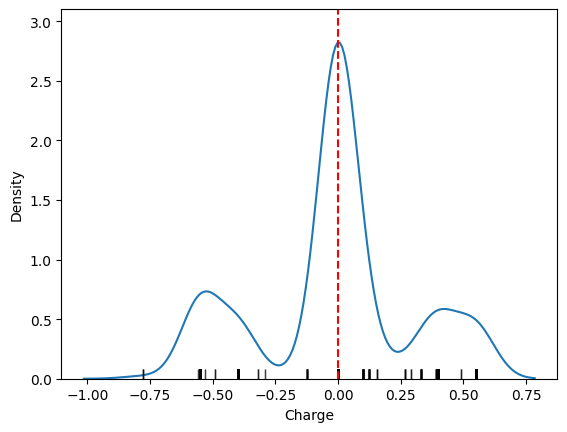

In [21]:
# Plotting the KDE Plot
sns.kdeplot(efield_dfx, x='charge')#, hue = "Res", lw=0.5)
sns.rugplot(efield_dfx, x='charge', color="black", alpha=0.5).set(xlabel = "Charge", ylabel = "Density")
plt.axvline(x=0, color='red', linestyle='--', lw=1.5)

In [23]:
# Example:
pdb7adh = '../data/7/a/7adh_A/7adh_A_Rlx.pdb'; pdb121p = '../data/1/2/121p_A/121p_A_Rlx.pdb'
pdb4b3e = '../data/4/b/4b3e_G/4b3e_G_Rlx.pdb'; pdb1sum = '../data/1/s/1sum_B/1sum_B_Rlx.pdb'

pqr7adh = '../data/7/a/7adh_A/7adh_A.pqr'; pqr121p = '../data/1/2/121p_A/121p_A.pqr'
pqr4b3e = '../data/4/b/4b3e_G/4b3e_G.pqr'; pqr1sum = '../data/1/s/1sum_B/1sum_B.pqr'

dfchrg = charge_around_metal(pqr1sum, pdb1sum)
print(dfchrg.shape)
dfchrg.columns

/tmp/ipykernel_44865/450205633.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metpairs = pd.concat([metpairs, pd.DataFrame([new_row])], ignore_index=True)
/tmp/ipykernel_44865/1343876107.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_row = {'n': atom1[1], 'atom': atom1[2], 'resName': atom1[3], 'resN': atom1[4], 'chain': chain, 'metal': atom2[0], 'metalN': atom2[2],
/tmp/ipykernel_44865/1343876107.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

               atoms resName resN          x        y         z
0  FE237-FE238-NI301      FE  237  12.634167  42.1875      2.62
1  FE240-FE241-FE242      FE  240    27.1335   26.358  7.431167
2                 FE      FE  236     24.797   62.155    15.939
3                 FE      FE  239     19.276   45.198     0.853


/tmp/ipykernel_44865/1343876107.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_row = {'n': atom1[1], 'atom': atom1[2], 'resName': atom1[3], 'resN': atom1[4], 'chain': chain, 'metal': atom2[0], 'metalN': atom2[2],
/tmp/ipykernel_44865/1343876107.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'x': atom1[5], 'y': atom1[6], 'z': atom1[7], 'xm': atom2[3], 'ym': atom2[4], 'zm': atom2[5],
/tmp/ipykernel_44865/1343876107.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

(978, 22)


Index(['n', 'atom', 'resName', 'resN', 'chain', 'metal', 'metalN', 'x', 'y',
       'z', 'xm', 'ym', 'zm', 'distance', 'rx', 'ry', 'rz', 'charge', 'E',
       'Ex', 'Ey', 'Ez'],
      dtype='object')

In [32]:
def charge_around_metal(pqrpath, pdbpath, clusterdist_threshold=6, atomdist_threshold=10):
    dfpdb = pdb2table(pdbpath)
    dfpdb = dfpdb[dfpdb['type']== "HETATM"]
    dfmetals = metal_dist(dfpdb, clusterdist_threshold)
    print(dfmetals)
    dfpqr = pqr2table(pqrpath)
    chain = dfpdb.iloc[0,4]
    dfpqr.insert(4, 'chain', chain)
    # Pairwise metal to atom distance
    dfpqr_arr = dfpqr[['x', 'y', 'z']].values
    dfmetals_arr = dfmetals[['x', 'y', 'z']].values
    distance_matrix = np.linalg.norm(dfpqr_arr[:, None] - dfmetals_arr, axis=-1)
    print(distance_matrix)

    # Filter pairs based on the distance threshold
    filtered_indices = np.argwhere(distance_matrix <= atomdist_threshold)

    # Iterate over the filtered pairs
    for i, j in filtered_indices:
        atom1 = dfpqr.iloc[i]
        atom2 = dfmetals.iloc[j]
        distance = distance_matrix[i, j]
        print(i, j, distance)
    #dfpqr = pd.concat([dfpqr, dfpdb], ignore_index=True)
    #nr = dfpdb.shape[0]
    #print(nr)
#    if nr > 1:
#        print(nr, "Metals \t Cluster?")
#        print(metal_dist(dfpdb))
#    else:
#        print(nr, "Metals \t Single?")
    return #dfpqr
#dist = np.linalg.norm(vectors[i]-vectors[j])

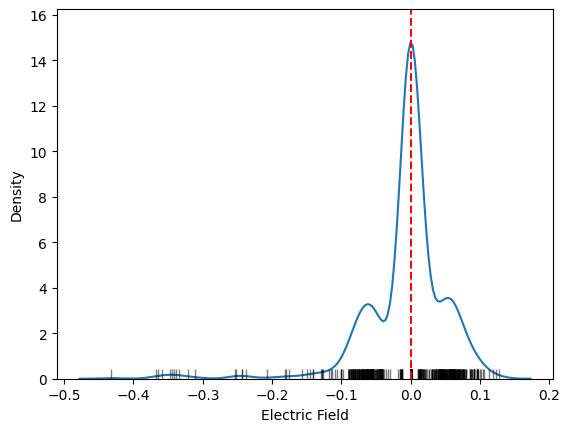

In [35]:
# Plotting the KDE Plot
sns.kdeplot(efield_dfx, x='E')#, hue = "Res", lw=0.5)
sns.rugplot(efield_dfx, x='E', color="black", alpha=0.5).set(xlabel = "Electric Field", ylabel = "Density")
plt.axvline(x=0, color='red', linestyle='--', lw=1.5)

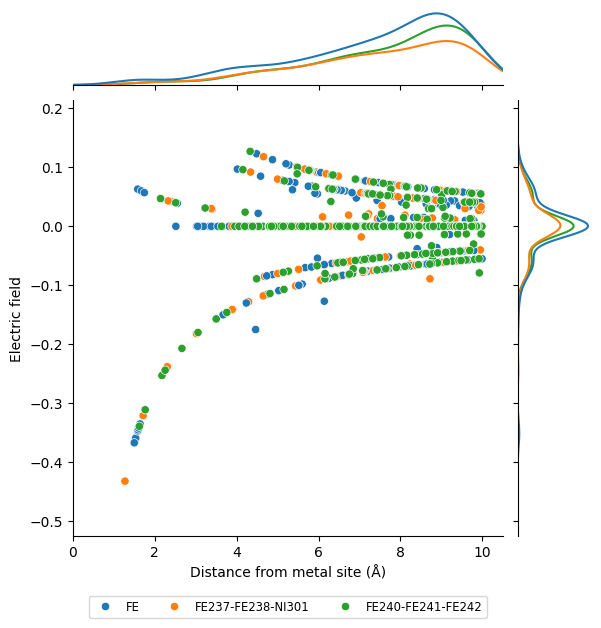

In [36]:
df = efield_dfx.copy()
g = sns.jointplot(data=df, x="distance", y="E", hue="metal", kind='scatter',
                  marginal_kws={'fill':False})
#plt.ylim(-0.5, 0.5)
plt.xlim(0, 10.5)
plt.xlabel("Distance from metal site (Å)")
plt.ylabel("Electric field")
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol = 4, fontsize='small')
plt.show()

In [34]:
# Electric field by residue
def elecfield_byres(pqrpath, pdbpath, cluster_maxdist=5, atomdist_shell=10):
    ef_dfx = charge_around_metal(pqrpath, pdbpath, cluster_maxdist, atomdist_shell)
    ef_dftemp = efield_dfx[efield_dfx['atom', 'resName', 'resN', 'metal', 'distance', 'charge', 'E']]
    ef_dftemp = efield_dfx[efield_dfx['atom', 'resName', 'resN', 'metal', 'distance', 'charge', 'E']]

In [26]:
import math 
import sys

def Rg(filename):
	coord = list()
	mass = list()
	Structure = open(filename, 'r')
	for line in Structure:
		try:
			line = line.split()
			x = float(line[6])
			y = float(line[7])
			z = float(line[8])
			coord.append([x, y, z])
			if line[-1] == 'C':
				mass.append(12.0107)
			elif line[-1] == 'O':
				mass.append(15.9994)
			elif line[-1] == 'N':
				mass.append(14.0067)
			elif line[-1] == 'S':
				mass.append(32.065)
		except:
			pass
	xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
	tmass = sum(mass)
	rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
	mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
	rg = math.sqrt(rr / tmass-mm)
	return(round(rg, 3))

In [29]:
pdb4b3e = '../data/7/a/7adh_A/7adh_A_Rlx.pdb'
Rg(pdb4b3e)

16.124